In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
import tensorflow as tf

data_dir = '/Users/sasiabburi/Downloads/Tomato disease prediction'

# Load images directly from subfolders
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = dataset.class_names
n_classes = len(class_names)

Found 16011 files belonging to 10 classes.


2025-05-08 15:21:34.062861: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-08 15:21:34.062899: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-08 15:21:34.062910: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746697894.062928  271408 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746697894.062953  271408 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
n_classes

10

In [6]:
len(dataset)

501

2025-05-08 15:21:34.425250: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


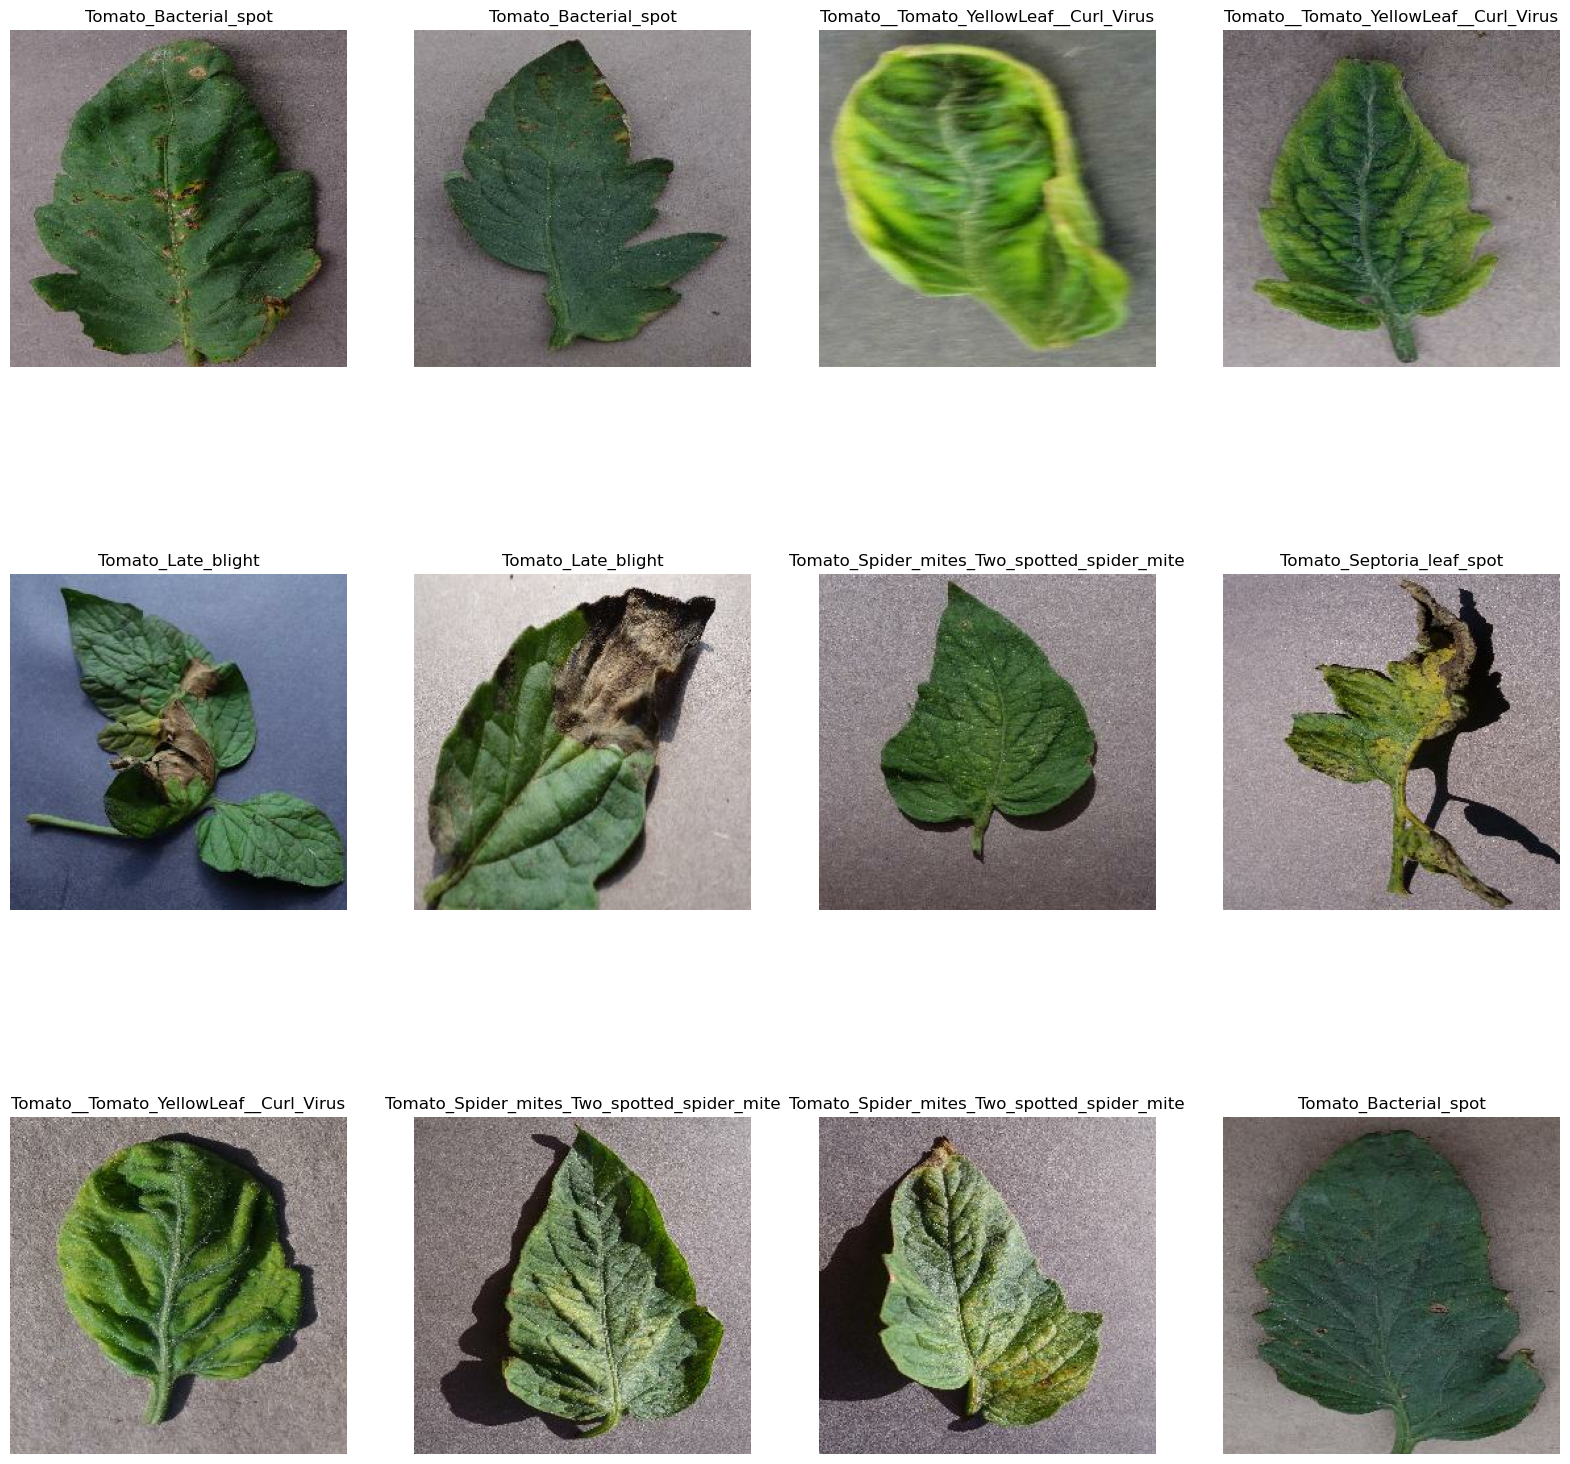

In [7]:
plt.figure(figsize = (20,20))
for image_size,label_size in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_size[i].numpy().astype("uint8"))
        plt.title(class_names[label_size[i]])
        plt.axis("off")
                  
        

In [8]:
len(dataset)

501

In [9]:
# 80% of data is for training
# 20% of data ==> 10% for validation , 10% for testing
'''train_size = 0.8
len(dataset) * train_size'''

'train_size = 0.8\nlen(dataset) * train_size'

In [10]:
'''train_dataset = dataset.take(400) # this is train_dataset
len(train_dataset)'''

'train_dataset = dataset.take(400) # this is train_dataset\nlen(train_dataset)'

In [11]:
'''test_dataset = dataset.skip(400)
len(test_dataset)'''

'test_dataset = dataset.skip(400)\nlen(test_dataset)'

In [12]:
'''val_size = 0.1
len(dataset) * val_size
'''

'val_size = 0.1\nlen(dataset) * val_size\n'

In [13]:
'''val_ds = test_dataset.take(50)  #validation_dataset
len(val_ds)'''

'val_ds = test_dataset.take(50)  #validation_dataset\nlen(val_ds)'

In [14]:
'''test_dataset = test_dataset.skip(50) #test_dataset
len(test_dataset)'''

'test_dataset = test_dataset.skip(50) #test_dataset\nlen(test_dataset)'

In [15]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
    ds_size = len(dataset)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [17]:
len(train_ds) # train_dataset = train_ds

400

In [18]:
len(val_ds) #val_ds = val_ds

50

In [19]:
len(test_ds) #test_dataset = test_ds

51

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
#resize and rescale layer - resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
# data augmentation layer - horizontal and vertical flip
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [22]:
from tensorflow.keras import regularizers

model = models.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation="relu", padding="same",
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same",
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same",
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),  # slightly reduced dropout for balance

    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation="softmax")
])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [25]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available: 1


In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5930 - loss: 1.4650

2025-05-08 15:33:16.984244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 342 of 10000
2025-05-08 15:33:22.218515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


400/400 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.5931 - loss: 1.4649 - val_accuracy: 0.5794 - val_loss: 1.5486
Epoch 2/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.6593 - loss: 1.2574 - val_accuracy: 0.5881 - val_loss: 1.7371
Epoch 3/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 382s 955ms/step - accuracy: 0.7140 - loss: 1.1052 - val_accuracy: 0.5206 - val_loss: 2.5850
Epoch 4/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 389s 972ms/step - accuracy: 0.7228 - loss: 1.0621 - val_accuracy: 0.4313 - val_loss: 3.4955


In [46]:
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")

NameError: name 'ModelCheckpoint' is not defined

In [48]:
import os
print(os.listdir())

['download (1).png', '.Rhistory', 'hello.dSYM', '.config', '.html', 'Music', 'HTM', '.kaggle', 'x=int(input("enter a number")).py', '.condarc', 'cpprogramming', 'arr=list(map(int, input("enter the eleme.py', 'py', 'index.html', '.DS_Store', 'arr=list(map(int, input("enter the value.py', '.CFUserTextEncoding', '.xonshrc', 'BTC-USD.csv', 'Tomato leaf disease detection using CNN ML.ipynb', 'anaconda_projects', 'images', '.zshrc', 'afford', 'best_model.keras', 'workshop.py', 'gy.html', '.local', 'landing page', 'Pictures', 'new file', 'hi.html', '.zprofile', 'jo.R', 'bitcoin price prediction using lstm.ipynb', '.zsh_history', '.ipython', 'Desktop', 'Library', 'html', '.matplotlib', 'jjff', 'hello.cpp', 'kii', 'srinath.cpp', 'bitcoinpriceprediction.py', 'Public', 'Bitcoin_prediction.ipynb', '.idlerc', 'cpp', '.tcshrc', '.RData', '.virtual_documents', 'bitcoin_prediction.py', '.anaconda', 'python.py', 'Movies', 'Applications', '.Rapp.history', '.Trash', '.ipynb_checkpoints', '.jupyter', '.ke

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

In [52]:
model.save("best_model.keras")

In [54]:
import os
print(os.listdir())

['download (1).png', '.Rhistory', 'hello.dSYM', '.config', '.html', 'Music', 'HTM', '.kaggle', 'x=int(input("enter a number")).py', '.condarc', 'cpprogramming', 'arr=list(map(int, input("enter the eleme.py', 'py', 'index.html', '.DS_Store', 'arr=list(map(int, input("enter the value.py', '.CFUserTextEncoding', '.xonshrc', 'BTC-USD.csv', 'Tomato leaf disease detection using CNN ML.ipynb', 'anaconda_projects', 'images', '.zshrc', 'afford', 'best_model.keras', 'workshop.py', 'gy.html', '.local', 'landing page', 'Pictures', 'new file', 'hi.html', '.zprofile', 'jo.R', 'bitcoin price prediction using lstm.ipynb', '.zsh_history', '.ipython', 'Desktop', 'Library', 'html', '.matplotlib', 'jjff', 'hello.cpp', 'kii', 'srinath.cpp', 'bitcoinpriceprediction.py', 'Public', 'Bitcoin_prediction.ipynb', '.idlerc', 'cpp', '.tcshrc', '.RData', '.virtual_documents', 'bitcoin_prediction.py', '.anaconda', 'python.py', 'Movies', 'Applications', '.Rapp.history', '.Trash', '.ipynb_checkpoints', '.jupyter', '.ke

In [56]:
#### 🛠️ Step 2: **Did you actually save the model before?**

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")